**Image Annotation**

In [4]:
# Check that we are on GPU
!nvidia-smi

Sun Jun 23 12:34:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Create Home variable
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Clone GroundingDINO repo and pip install roboflow
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

!pip install -q -e .
!pip install -q roboflow

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [7]:
# Pip install supervision
#!pip install supervision==0.4.0

  Attempting uninstall: supervision
    Found existing installation: supervision 0.21.0
    Uninstalling supervision-0.21.0:
      Successfully uninstalled supervision-0.21.0


In [1]:
# Import libraries
import supervision as sv
import roboflow
import torch

In [6]:
# Check that file exists
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [7]:
# Download weights into a weights folder
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [9]:
# Check that weights file exists
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [10]:
# Import libraries from groundingDINO and load model
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
grounding_dino_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
# Image path and text prompt
IMAGE_PATH = "/content/drive/MyDrive/Computer Vision/data/rat_20.jpg"
TEXT_PROMPT = "rat"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


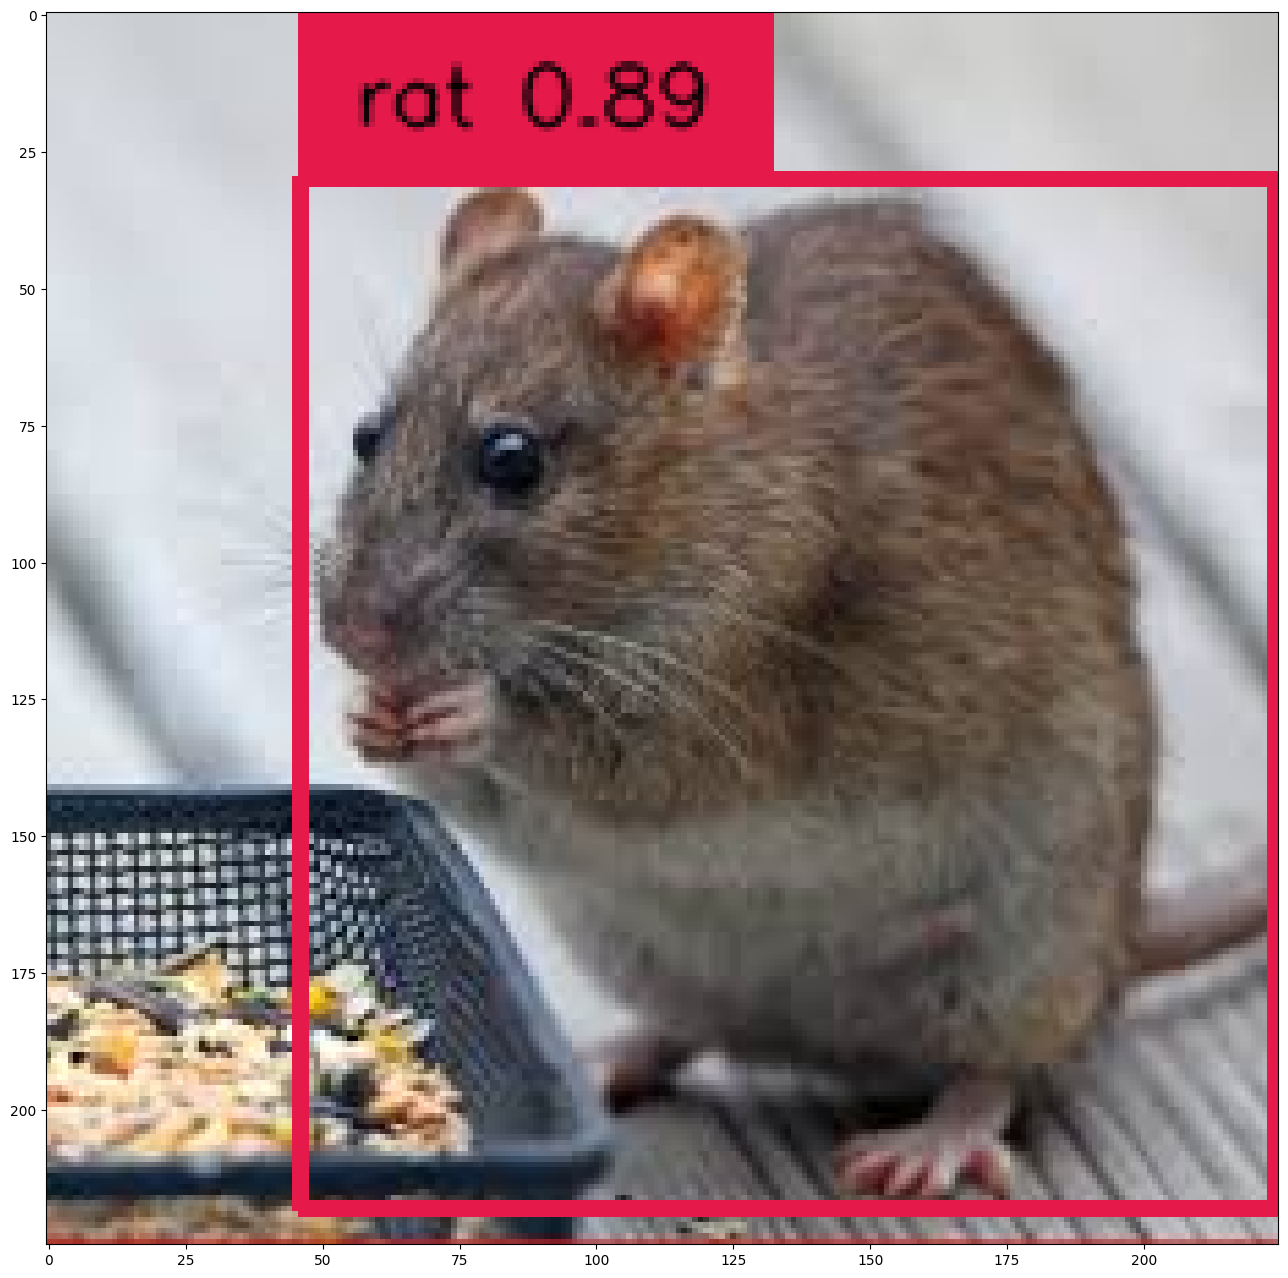

In [14]:
# Check GroundingDINO annotation on a single image
import matplotlib.pyplot as plt
from PIL import Image

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=grounding_dino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source,boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [15]:
# Log in to Roboflow
import roboflow
from roboflow import Roboflow
roboflow.login()

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [18]:
# Set up variables to load project
PROJECT_NAME = "rat-detector"
PROJECT_DESCRIPTION = "rat"
SOURCE_DIRECTORY_PATH = os.path.join(HOME, "drive/MyDrive/Computer Vision/data")
CLASSES = ['rat']

In [19]:
# Create new, empty project in Roboflow
workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation=PROJECT_DESCRIPTION)

loading Roboflow workspace...
loading Roboflow project...


In [20]:
# Make model
grounding_dino_model = Model(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


In [21]:
# Enhance classes using prompt engineering
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [23]:
# Dataset auto annotation
def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files

def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)

def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

In [25]:
# Detect and upload annotations to new project
from os import listdir
import cv2

for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    # detections = detections.with_nms()

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
